<h2>Intro</h2>
<p>The following presentation aims to describe the steps needed to perform the aerodynamic analysis of a <b>viscous flow</b> around a an airfoil (e.g. NACA 4418) with the support of the <a href="https://github.com/daniel-de-vries/xfoil-python"><b>xfoil library</b></a>.</p>
<p>The results are also compared against non viscous flow and expiremental data at different <b>angles of attack</b> (&alpha;) and <b>reynolds number</b> (Re).</p>

<h2>Airfoil characteristics - NACA 4-digits</h2>
<div>
  <img src="../Images/airfoil_definitions.png"/>
</div>
<p>The NACA four-digit wing sections define the profile by:
    <ul>
        <li><b>m</b>: first digit describing maximum camber as percentage of the chord.</li>
        <li><b>p</b>: second digit describing the distance of maximum camber from the airfoil leading edge in tenths of the chord.</li>
        <li><b>ss</b>: last two digits describing maximum thickness of the airfoil as percent of the chord.</li>
    </ul>
</p>
<p>The airfoil thikness <b>Y</b> can be calculated with the following formula:
    $$ Y = 5ss(0.29690\sqrt{x}-0.12600x-0.35160x^{2}+0.28430x^{3}-0.10150x^{4}) $$
</p>
<p>The camber line <b>C</b> and its gradient <b>dC</b> are calculated as follows:
    <ul>
        <li>for $x<=p$ (front):
            $$ C_{f} = \frac{m}{p^{2}}(2px - x^{2}) $$
            $$ dC_{f} = \frac{2m}{p^{2}}(p - x) $$
        </li>
        <li>for $x>p$ (back):
            $$ C_{b} = \frac{m}{(1 - p)^{2}}(1 - 2p + 2px - x^{2}) $$
            $$ dC_{b} = \frac{2m}{(1 - p)^{2}}(p - x) $$
        </li>
    </ul>
</p>
<p>By knowing these 3 quantities we can finally calculate the positions of the upper and lower surface of the airfoil as they are perpendicular to the camber line:
    $$ \theta = \arctan(dC)$$
    $$ X_{u} = x - Y\sin(\theta)$$
    $$ Y_{u} = C + Y\cos(\theta)$$
    $$ X_{l} = x + Y\sin(\theta)$$
    $$ Y_{l} = C - Y\cos(\theta)$$
</p>
<p>Learn more about it here:
    <ul>
        <li><a href="http://airfoiltools.com/airfoil/naca4digit">http://airfoiltools.com/airfoil/naca4digit</a></li>
        <li><a href="https://en.wikipedia.org/wiki/NACA_airfoil">https://en.wikipedia.org/wiki/NACA_airfoil</a></li>
    </ul>
</p>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>

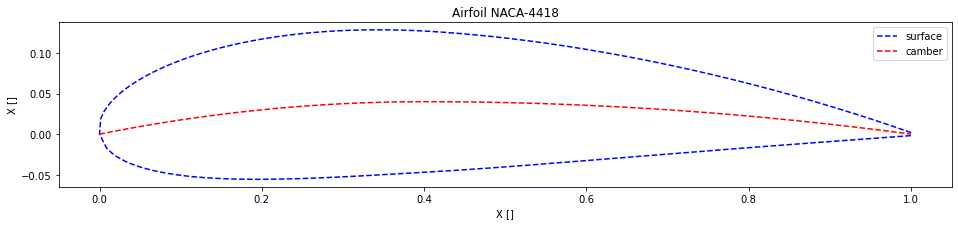

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from xfoil import XFoil


class NACA():
    def __init__(self, x, y, c, C, n_coords, series):
        self.x = x
        self.y = y
        self.c = c
        self.C = C
        self.n_coords = n_coords
        self.series = series
        self.coeff_dict = {}
        
    def plot(self):  
        plt.figure(figsize=(16,9))
        plt.plot(self.x, self.y, 'b--', label='surface')
        plt.plot(self.c, self.C, 'r--', label='camber')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().legend()
        plt.xlabel('X []')
        plt.ylabel('X []')
        plt.title('Airfoil NACA-{}'.format(self.series))
        plt.savefig(os.path.join('../Images', self.series+'.png'))
        plt.show()
        
    def calculate_coefficients(self, alpha_min, alpha_max, alpha_step, Re=None):
        
        # Create an instance of class
        xf = XFoil()

        # Add information about the airfoil geometry
        xf.airfoil = self

        # Add information about Re if viscous
        if Re:
            xf.Re = Re

        # Max number of iterations
        xf.max_iter = 40

        # Calcualte lift, drag, momentum, pressure coefficients
        a, cl, cd, cm, cp = xf.aseq(alpha_min, alpha_max, alpha_step)
        
        # Store coefficients for new configuration
        self.coeff_dict[str(alpha_min)+'_'+str(alpha_max)+'_'+str(alpha_step)+'_'+str(Re)] = {'a':a, 'cl':cl, 'cd':cd, 'cm':cm, 'cp':cp}
    
    def plot_coefficients(self, configuration):
        
        # extract coefficients info
        config = self.coeff_dict[configuration]
        a = config['a']
        cl = config['cl']
        cd = config['cd']
        cm = config['cm']
        cp = config['cp']
        
        # plot lift coefficient
        plt.figure(figsize=(12,9))
        plt.plot(a, cl, 'b', label='cl')
        plt.gca().legend()
        plt.xlabel('alpha [deg]')
        plt.ylabel('CL []')
        plt.title('CL/\u03B1 NACA-{}'.format(naca4418.series))
        plt.show()

        # plot drag coefficient
        plt.figure(figsize=(12,9))
        plt.plot(a, cd, 'b', label='cl')
        plt.gca().legend()
        plt.xlabel('alpha [deg]')
        plt.ylabel('CD []')
        plt.title('CD/\u03B1 NACA-{}'.format(naca4418.series))
        plt.show()

        # plot moment coefficient
        plt.figure(figsize=(12,9))
        plt.plot(a, cm, 'b', label='cl')
        plt.gca().legend()
        plt.xlabel('alpha [deg]')
        plt.ylabel('CM []')
        plt.title('CM/\u03B1 NACA-{}'.format(naca4418.series))
        plt.show()
        
        
def naca_4_digits_coordinates(naca, n_coords=500):
    '''
    This function generates the the coordinates of 
    the upper and lower surface of the airfoil and the
    coordinates of the camberline as well. All coordinates
    are adimentional.
    
    Inputs:
        - naca: string. 4 digits naca code (ex: 4418)
        - n: integer. Number of points to discretize airfoil surface
        - plot: boolean. If False, no airfoil plot
    Outputs:
        - X: float. Horizontal coordinates of the airfoil surface
        - Y: float. Vertical coordinates of the airfoil surface
        - c: float. Horizontal coordinates of the camber line
        - C: float. Vertical coordinates of the camber line
    '''
    if len(naca)!=4:
        raise Exception('Naca is not a 4 digit series!')
    
    # Get characteristic dimensions as percentage of the chord
    m = int(naca[0])/100
    p = int(naca[1])/10 + np.finfo(float).eps
    ss = int(naca[2:])/100

    # Define unit cord
    c = np.linspace(0, 1, int(n_coords/2))

    # Calculate airfoil thickness
    Y = 5*ss*(0.29690*np.sqrt(c)-0.12600*c-0.35160*np.power(c, 2)+0.28430*np.power(c, 3)-0.10150*np.power(c, 4))

    # Calculate camber line and gradient
    f = c[c<=p] # front
    b = c[c>p] # back
    c_f = m/(np.power(p, 2))*(2*p*f-np.power(f, 2))
    c_b = m/np.power(1-p, 2)*(1-2*p+2*p*b-np.power(b, 2))

    C = np.concatenate((c_f, c_b), axis=0)
    dc_f = 2*m/(np.power(p,2))*(p-f)
    dc_b = 2*m/(np.power(1-p,2))*(p-b)
    dC = np.concatenate((dc_f, dc_b), axis=0)

    # Calcualate upper and lower surface coordinates of the airfoil
    theta = np.arctan(dC)
    x_u = c - Y*np.sin(theta)
    y_u = C + Y*np.cos(theta)
    x_l = c + Y*np.sin(theta)
    y_l = C - Y*np.cos(theta)

    x = np.concatenate((np.flip(x_u), x_l), axis=0)
    y = np.concatenate((np.flip(y_u), y_l), axis=0)
    
    return NACA(x, y, c, C, n_coords, naca)

naca4418 = naca_4_digits_coordinates('4418', n_coords=400)
naca4418.plot()

<h2>Lift and drag coefficient</h2>
<p>For the viscous analysis 2 different Reynold's number have been considered: <i>Re=200000</i> and <i>Re=600000</i>. The latter represents better aeronautical flows. Such number is defined as:</p>
$$ Re = \frac{vD\rho}{\mu}$$
<p>Where <i>v</i>, <i>D</i> and <i>&rho;</i> are respectively the relative velocity object-ariflow, the characteristic dimension of the object and the air density. It can be interpreted as the ratio between inertial and viscous forces and allows to predict the transition from laminar to turbulent flows.
For the inviscid flows, the Re number loses it's meaning as there is no viscosity <i>&mu;</i>. More about the Reynold's number can be found <a href="https://en.wikipedia.org/wiki/Reynolds_number">here</a>.</p>
<p>Let's now calculate the lift coefficient <i>CL</i> and the drag coefficient <i>CD</i> (when possible) in the different scenarios:</p>

In [14]:
naca4418.calculate_coefficients(-20, 20, 0.5, Re=None)
naca4418.calculate_coefficients(-20, 20, 0.5, Re=200000)
naca4418.calculate_coefficients(-20, 20, 0.5, Re=600000)

<h2>Plot coefficients</h2>
<p>The aerodynamic coefficients are note calculated at different conditions in such a way to consider also viscous phonomena. For this example a <i>Re=600000</i> is used.</p>

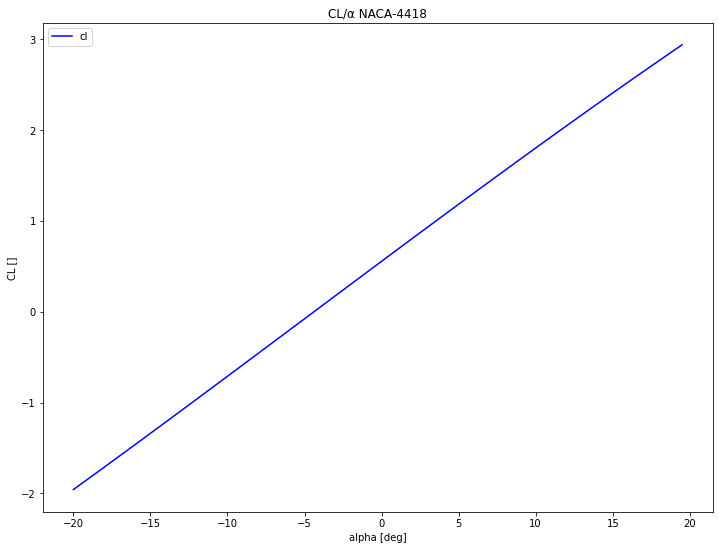

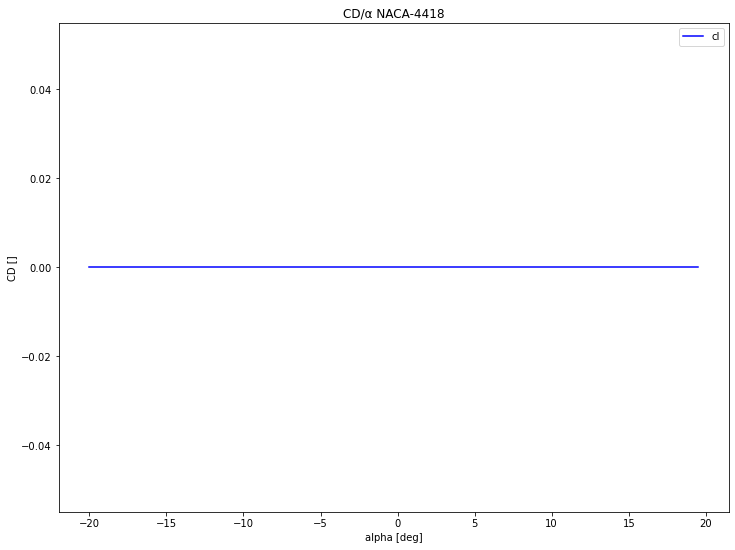

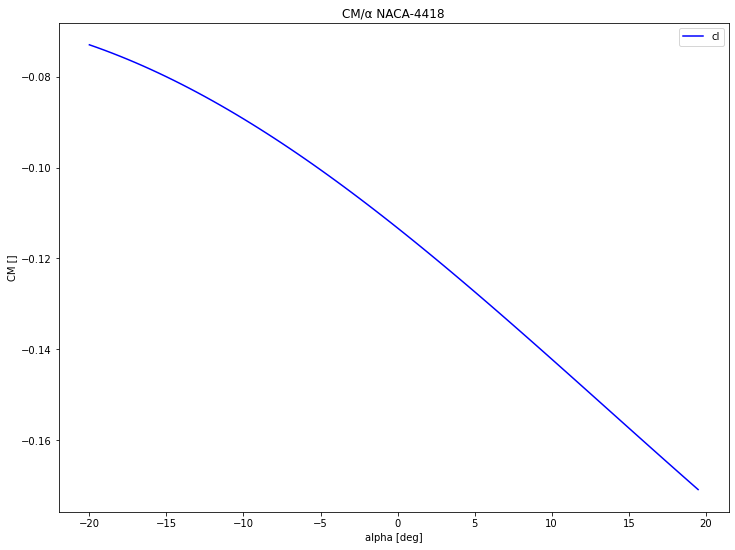

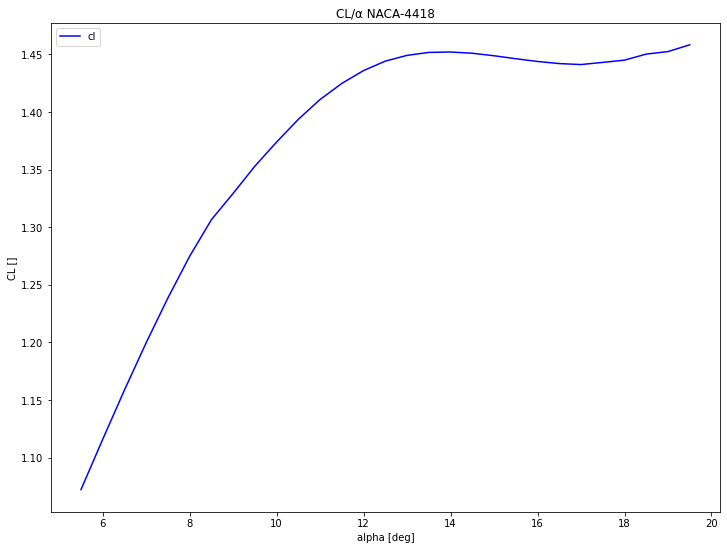

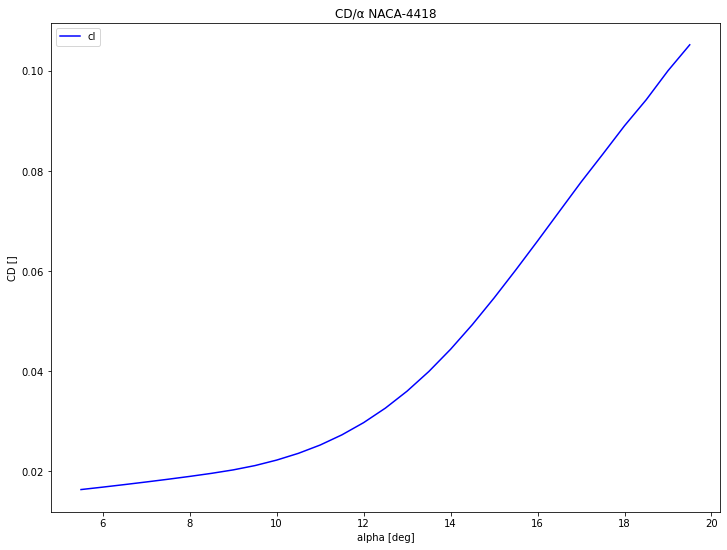

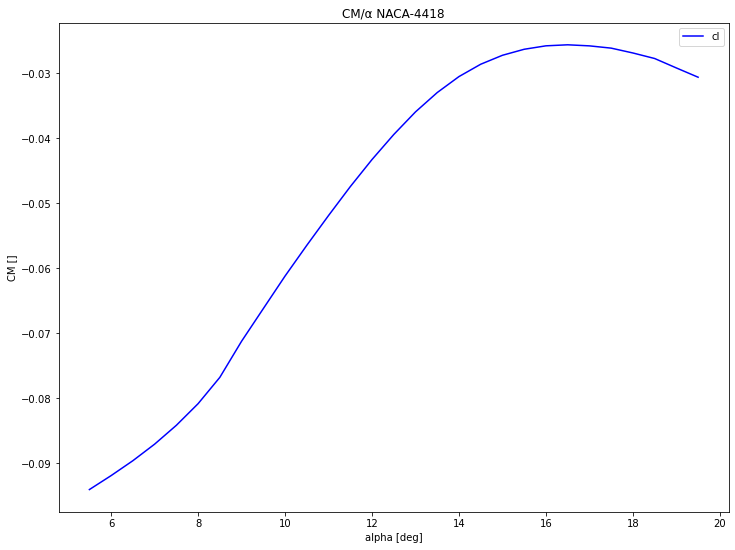

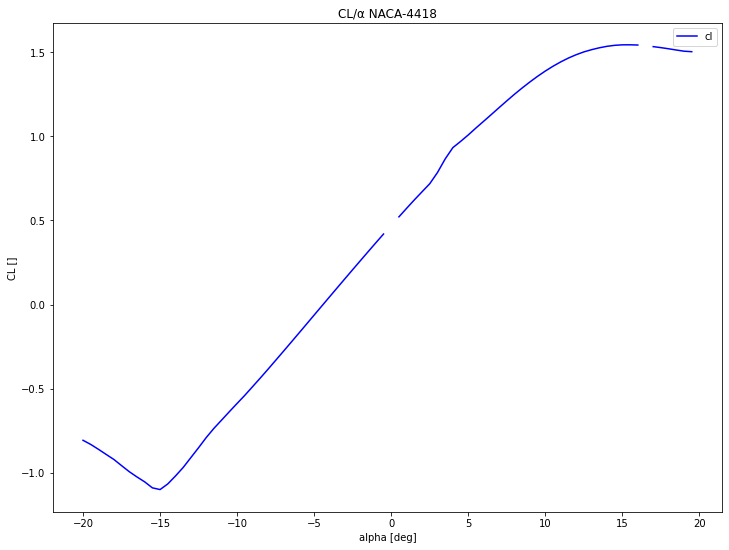

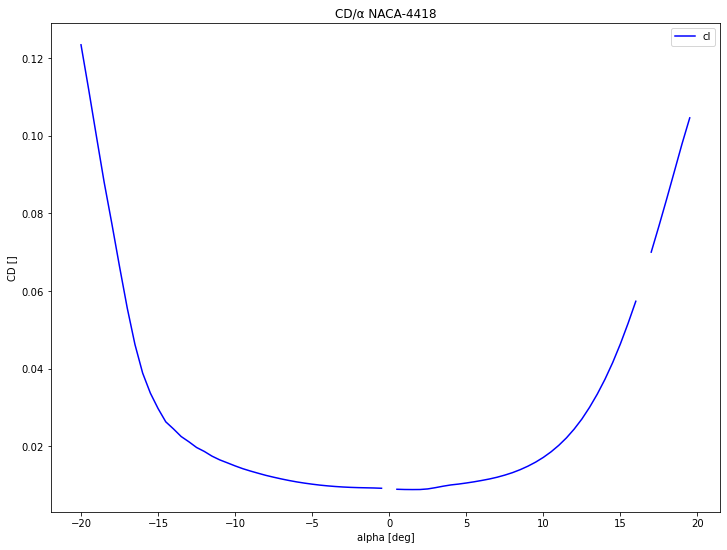

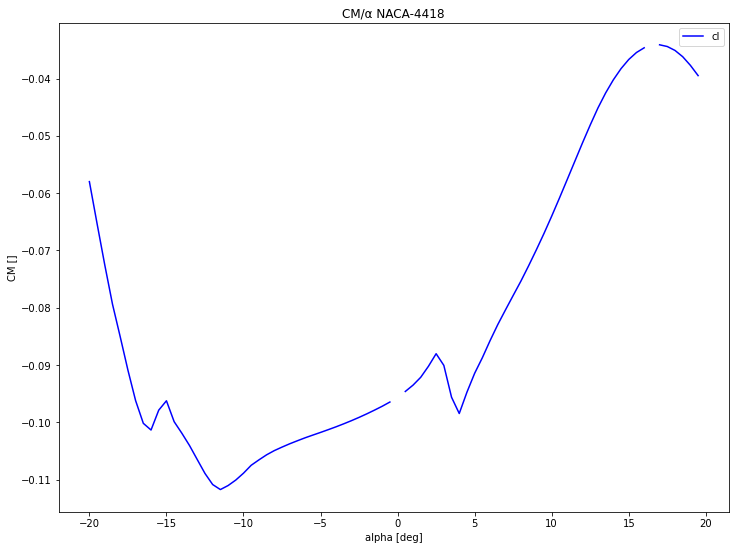

In [15]:
naca4418.plot_coefficients('-20_20_0.5_None')
naca4418.plot_coefficients('-20_20_0.5_200000')
naca4418.plot_coefficients('-20_20_0.5_600000')

<h2>Sample experimental data</h2>
<p>In order to understand the correctness of the calculated data, it can be helpful to have a comparison against experimental records. Fortunatelly NASA provides what we need thanks to the <a href="https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf">REPORT No. 824 SUMMARY OF AIRFOIL DATA By IRA H. ABBOTT, ALBERT E. VON DOENHOFF, and LOUIS S. STIVERS, Jr.</a> which contains many examples of experimental data for a great range of naca airfoils and Reynold's numbers.</p>
<p>Notice how such data is not in a machine readable format and therefore it requires some special treatment. In this case we need to sample the pixels representing the desired aerodynamic coefficient curve and convert it to the right scale.</p>

In [3]:
import cv2
import os
import numpy as np

x_coord = []
y_coord = []
def mouse_points(event, x, y, flag, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        x_coord.append(x)
        y_coord.append(-y + param[0])
        
        print('{}, {}'.format(x, -y + param[0]))

def sample_experimental_data(filename, image, x_range, y_range):
    
    # Read image
    img = cv2.imread(os.path.join('../Images', image))
    
    if os.path.isfile(os.path.join('../Data', filename)):
        
        f = open(os.path.join('../Data', filename), "r")
        content = f.read()
        for row in content.split("\n")[:-1]:
            x_coord.append(int(row.split(',')[0]))
            y_coord.append(int(row.split(',')[1]))
        f.close()
    
    # sample experimental data  
    else:
        
        # Show the image with cv2
        cv2.imshow('img', img)
        
        # Get mouse coordinates from image
        param = img.shape
        cv2.setMouseCallback('img', mouse_points, param)

        # Close Image
        cv2.waitKey(0)
        cv2.destroyWindow('img')

        # save data
        f = open(os.path.join('../Data', filename), "w")
        for x, y in list(zip(x_coord, y_coord)):
            f.write("{},{}\n".format(x,y))
        f.close()

    # Convert data to correct units
    x_exp = x_range[0] + ((x_range[1]-x_range[0])/img.shape[1])*np.array(x_coord)
    y_exp = y_range[0] + ((y_range[1]-y_range[0])/img.shape[0])*np.array(y_coord)
    
    return x_exp, y_exp

a_exp, cl_exp = sample_experimental_data('cl_4418_600000_.txt', 'cl_cm_alpha.PNG', [-32,32], [-2, 3.6])

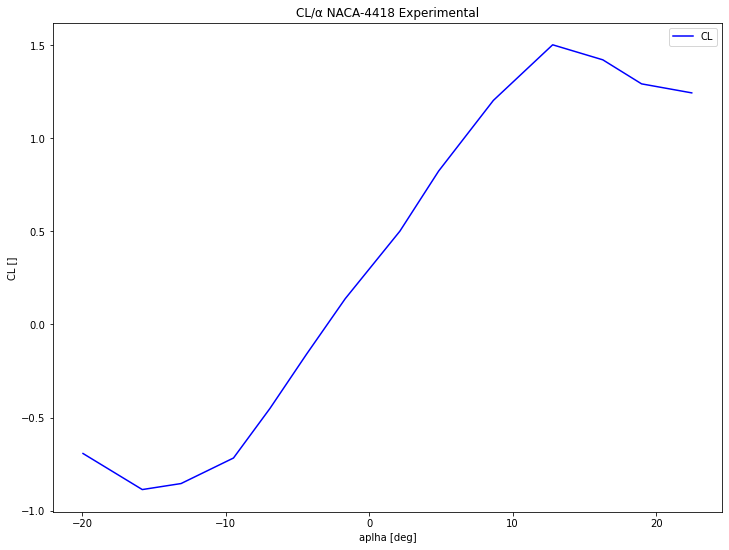

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))
plt.plot(a_exp, cl_exp, 'b', label='CL')
plt.gca().legend()
plt.xlabel('aplha [deg]')
plt.ylabel('CL []')
plt.title('CL/\u03B1 NACA-{} Experimental'.format('4418'))
plt.show()

<h2>Compare calculated and experimental data</h2>
<p>It can be observed that at <i>Re=600000</i> the curves for inviscid and viscous flow are pretty similar for small angles of attack <i>&alpha;</i>. However at greater or lower angles the viscous effects are more relevant and cause the separation of the flow over the airfoil thus generating a great drop in the lift coefficient <i>Cl</i> (blue and red curves).</p>
<p>Keep in mind that according to the definition of Reynold's number, the viscous effects tend to be smaller and smaller as <i>Re</i> increases thus making the blue and red curve closer to the black line.</p>

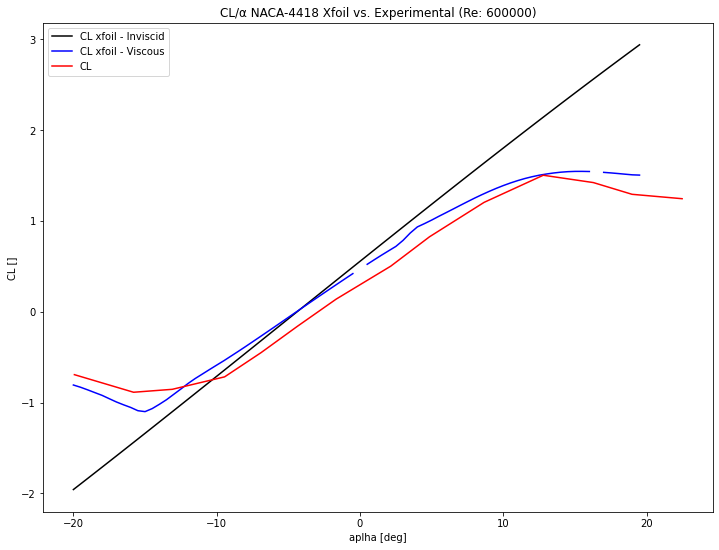

In [18]:
plt.figure(figsize=(12,9))
plt.plot(naca4418.coeff_dict['-20_20_0.5_None']['a'], naca4418.coeff_dict['-20_20_0.5_None']['cl'], 'k', label='CL xfoil - Inviscid')
plt.plot(naca4418.coeff_dict['-20_20_0.5_600000']['a'], naca4418.coeff_dict['-20_20_0.5_600000']['cl'], 'b', label='CL xfoil - Viscous')
plt.plot(a_exp, cl_exp, 'r', label='CL')
plt.gca().legend()
plt.xlabel('aplha [deg]')
plt.ylabel('CL []')
plt.title('CL/\u03B1 NACA-{} Xfoil vs. Experimental (Re: {})'.format(naca4418.series, 600000))
plt.show()